# Wrangle & Analyze Data
> _**WeRateDogs Twitter Archive**_
>
> **Guilherme Luciano Maffezzolli**
>
> _August 2021_

---
<a id='intro'></a>
## <font color = 'blue'> Introduction </font>
WeRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog. The archive we will work with contains over 2300 tweets with basic data (tweet ID, timestamp, text, etc.) and forms the basis of this analysis. 
Using Python and its libraries, we will gather data related to this account in a variety of formats, assess its quality and tidiness, clean it, and then provide analyses and visualizations. 

---
## <font color = 'blue'> Gathering </font>

### 1. WeRateDogs Twitter archive

> The WeRateDogs Twitter archive was provided and manually downloaded.

In [2]:
#let's first import a set of useful libraries for our project:
import pandas as pd
import numpy as np
import requests
import os
import tweepy
import json
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")
# display the full string
pd.options.display.max_rows
pd.set_option('display.max_colwidth', -1)
# Set default display parameter for plots.
plt.rcParams['figure.figsize'] = (8, 5)

In [3]:
# define a dataframe to read this file:
df_twitter = pd.read_csv('twitter-archive-enhanced.csv')

In [4]:
# here I'll perform some checks to understand the dataset I'm working with:
df_twitter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [5]:
df_twitter.head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None


### 2. Tweet image predictions

>  This file was hosted on Udacity's servers will be downloaded programmatically using the Requests library.

In [6]:
# using the provided link, I am downloading the file:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)
response

<Response [200]>

In [7]:
# 200 means that the request worked 
with open(os.path.join('./', 'image-predictions.tsv'), mode = 'wb') as file:
    file.write(response.content)

In [8]:
# read the file
df_predictions = pd.read_csv('image-predictions.tsv', sep = '\\t', engine = 'python')
df_predictions.head(3)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True


### 3. Tweets data from Twitter API 

>  In this step I decided to follow the directions for accessing the Twitter data without actually creating a Twitter account. It is done by using both provided files twitter_api.py and tweet_json.txt. I also pasted the provided code below.

if==0:
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer

### Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
### These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

### NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES:
### df_1 is a DataFrame with the twitter_archive_enhanced.csv file. You may have to
### change line 17 to match the name of your DataFrame with twitter_archive_enhanced.csv
### NOTE TO REVIEWER: this student had mobile verification issues so the following
### Twitter API code was sent to this student from a Udacity instructor
### Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = df_twitter.tweet_id.values
len(tweet_ids)

### Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
### Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

Let's now read this .txt file line by line into a pandas DataFrame and extract the required fields from each tweet's JSON data to store it in a separate file, tweets_data.csv.

In [9]:
# read in the JSON data from the text file, and save to a DataFrame
tweets_json = []

with open('tweet-json.txt', 'r') as json_file:
    line = json_file.readline()
    while line:
        data = json.loads(line)
        data_id = data['id']
        data_retweet_count = data['retweet_count']
        data_favorite_count = data['favorite_count']
        
        # create a dictionary with the JSON data, then add to a list
        json_data = {'tweet_id': data_id, 
                     'retweet_count': data_retweet_count, 
                     'favorite_count': data_favorite_count
                    }
        tweets_json.append(json_data)
        line = json_file.readline()

# convert the tweet JSON data dictionary list to a DataFrame
df_tweets_data = pd.DataFrame(tweets_json, 
                                   columns = ['tweet_id',
                                              'retweet_count',
                                              'favorite_count'])

df_tweets_data.head(5)

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


In [10]:
df_tweets_data.to_csv('tweets_data.csv', index = False)

---
## <font color = 'blue'> Assessing </font>

> After gathering each of the above pieces of data, we will assess them visually and programmatically for quality and tidiness issues. I will open the files that I've created in the previous section and then assess one by one. As a project criteria, we must identify at least eight (8) quality issues and two (2) tidiness issues.

In [11]:
# opening the files:
df_twitter = pd.read_csv('twitter-archive-enhanced.csv')
df_predictions = pd.read_csv('image-predictions.tsv', sep = '\\t', engine = 'python')
df_tweets_data = pd.read_csv('tweets_data.csv')

### `df_twitter` 
(twitter-archive-enhanced.csv)

In [12]:
df_twitter.head(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None


In [13]:
df_twitter.tail(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a 1949 1st generation vulpix. Enjoys sweat tea and Fox News. Cannot be phased. 5/10 https://t.co/4B7cOc1EDq,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248165822465/photo/1,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a purebred Piers Morgan. Loves to Netflix and chill. Always looks like he forgot to unplug the iron. 6/10 https://t.co/DWnyCjf2mx,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226329800704/photo/1,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a very happy pup. Big fan of well-maintained decks. Just look at that tongue. 9/10 would cuddle af https://t.co/y671yMhoiR,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412701032449/photo/1,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a western brown Mitsubishi terrier. Upset about leaf. Actually 2 dogs here. 7/10 would walk the shit out of https://t.co/r7mOb2m0UI,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285002620928/photo/1,7,10,a,None,None,None,None
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a Japanese Irish Setter. Lost eye in Vietnam (?). Big fan of relaxing on stair. 8/10 would pet https://t.co/BLDqew2Ijj,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888022790149/photo/1,8,10,None,None,None,None,None


---
The functions `head()` and `tail()` are where I  usually start from when I am looking to to visually identify issues. These are some of the quality and tidiness issues I noticed:

**Quality:**
- There are 'None' values for name (745 entries according to the value_counts method on the following cell)
- Into the datasets' tail we can observe many name values as 'a', 'an', 'the', etc...

**Tidiness:**
- There are 4 columns for dog stages

We can get further information about the variables nature by using the `head()` method next.

In [14]:
df_twitter.name.value_counts().head(10)

None       745
a          55 
Charlie    12 
Lucy       11 
Oliver     11 
Cooper     11 
Tucker     10 
Penny      10 
Lola       10 
Winston    9  
Name: name, dtype: int64

In [15]:
df_twitter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

---
The `info()` method allows us to identify the following issues:

**Quality:**
- timestamp column is in 'object' type instead of 'datetime'
- 181 entries are retweets
- 78 entries are replies
- expanded_urls are available for 2297 rows and therefore 59 are missing

**Tidiness:**
- as we are only interested in original tweets, retweets related columns are not necessary once we get rid of retweets entries
- as we are only interested in original tweets, replies related columns are not necessary once we get rid of replies entries

In [16]:
# it is also important to verify if we have any duplicated rows
df_twitter.duplicated().sum()

0

In [17]:
df_twitter[['rating_numerator', 'rating_denominator']].describe()

,rating_numerator,rating_denominator
count,2356.000000,2356.000000
mean,13.126486,10.455433
std,45.876648,6.745237
min,0.000000,0.000000
25%,10.000000,10.000000
50%,11.000000,10.000000
75%,12.000000,10.000000
max,1776.000000,170.000000


---
Using the `describe()` function to better understand the rating numerators and denominators, we notice that:

**Quality:**
- the minimum value is zero for rating_denominator column
- the maximum value is different from 10 for the rating_denominator column
- there are too high values for the rating_numerator which can affect analysis

In [18]:
#let's observe the values that are different from 10 for denominator
df_twitter.rating_denominator.value_counts().sort_index()

0      1   
2      1   
7      1   
10     2333
11     3   
15     1   
16     1   
20     2   
40     1   
50     3   
70     1   
80     2   
90     1   
110    1   
120    1   
130    1   
150    1   
170    1   
Name: rating_denominator, dtype: int64

In [19]:
#let's observe the values that are too high for the numerator
df_twitter.rating_numerator.value_counts().sort_index()

0       2  
1       9  
2       9  
3       19 
4       17 
5       37 
6       32 
7       55 
8       102
9       158
10      461
11      464
12      558
13      351
14      54 
15      2  
17      1  
20      1  
24      1  
26      1  
27      1  
44      1  
45      1  
50      1  
60      1  
75      2  
80      1  
84      1  
88      1  
99      1  
121     1  
143     1  
144     1  
165     1  
182     1  
204     1  
420     2  
666     1  
960     1  
1776    1  
Name: rating_numerator, dtype: int64

In [20]:
# I also want to check which are the possible entries in the source column:
df_twitter.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                        91  
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                     33  
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>    11  
Name: source, dtype: int64

**Quality:**
- the definition of the source appears just before the '</a>' and the reverence between < > is not actually needed

### `df_predictions` 
(image-predictions.tsv)

In [21]:
df_predictions.head(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [22]:
df_predictions.tail(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2074,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False


In [23]:
# there doesn't seem to be issues in this first visual asessment
# let's take a look with info() method
df_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


**Quality:**
- there are only 2075 image predictions, while we have 2356 rows in the df_twitter table. Even if we drop replies (78) and retweets (181), there would possibly be 22 predictions missing.

### `df_tweets_data` 
(tweets_data.csv)

In [24]:
df_tweets_data.head(5)

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


**Tidiness:**
- As we already have another dataset containing the information related to each tweet (df_twitter), the information from this df_tweets_data should be combined to follow the rules of tidy data. 

---
## Assessment Results

### `df_twitter` 

**Quality:**
- [a] There are 'None' values for name (745 entries) **This one will not be cleaned**
- [b] Into the datasets' tail we can observe many name values as 'a', 'an', 'the', etc...
- [c] timestamp column is in 'object' type instead of 'datetime'
- [d] 181 entries are retweets
- [e] 78 entries are replies
- [f] expanded_urls are available for 2297 rows and therefore 59 are missing
- [g]  the maximum and minimum values are different from 10 for the rating_denominator column.
- [h] there are too high values for the rating_numerator which can affect analysis
- [i] the definition of the source appears just before the '' and the reverence between < > is not actually needed


**Tidiness:**
- [a] There are 4 columns for dog stages
- [b] as we are only interested in original tweets, retweets related columns are not necessary once we get rid of retweets entries
- [c] as we are only interested in original tweets, replies related columns are not necessary once we get rid of replies entries

### `df_predictions` 

**Quality:**
- [a] there are only 2075 image predictions, while we have 2356 rows in the df_twitter table. Even if we drop replies (78) and retweets (181), there would possibly be 22 predictions missing. **This one will not be cleaned**

### `df_tweets_data` 

**Tidiness:**
- [a] As we already have another dataset containing the information related to each tweet (df_twitter), the information from this df_tweets_data should be combined to follow the rules of tidy data. 

---
## <font color = 'blue'> Cleaning Data </font>

In [25]:
# I will create copies for cleaning each dataset
df_twitter_clean = df_twitter.copy()
df_predictions_clean = df_predictions.copy()
df_tweets_data_clean = df_tweets_data.copy()

### `df_twitter` 
**Quality:** [b] Into the datasets' tail we can observe many name values as 'a', 'an', 'the', etc... <br>
**Define:** Replace these words, which are all lowercase, with `none`.

In [26]:
name_list = df_twitter_clean.name.str.contains('^[a-z]', regex = True)
df_twitter_clean.loc[name_list, 'name'] = "none"

In [27]:
#test:
df_twitter_clean[name_list].name.value_counts().sort_index()

none    109
Name: name, dtype: int64

### `df_twitter` 
**Quality:** [c] timestamp column is in 'object' type instead of 'datetime' <br>
**Define:** Convert timestamp column to datetime type.

In [28]:
df_twitter_clean['timestamp'] = pd.to_datetime(df_twitter_clean.timestamp)

In [29]:
#test:
df_twitter_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: datetime64[ns](1

### `df_twitter` 
**Quality:** [d] 181 entries are retweets <br>
**Define:** Drop rows that are actually retweets.

In [30]:
# we know that retweets have the the retweeted_status_id info:
sum(df_twitter_clean.retweeted_status_id.notnull())

181

In [31]:
# so I'll clean it by selecting the rows with null entries
df_twitter_clean = df_twitter_clean[df_twitter_clean.retweeted_status_id.isna()]

In [32]:
#test:
df_twitter_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2175 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2175 non-null datetime64[ns]
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null int64
rating_denominator            2175 non-null int64
name                          2175 non-null object
doggo                         2175 non-null object
floofer                       2175 non-null object
pupper                        2175 non-null object
puppo                         2175 non-null object
dtypes: datetime64[ns](1), flo

### `df_twitter` 
**Quality:** [e] 78 entries are replies <br>
**Define:** Drop rows that are actually replies.

In [33]:
# we know that replies have the the in_reply_to_status_id info:
sum(df_twitter_clean.in_reply_to_status_id.notnull())

78

In [34]:
# so I'll clean it by selecting the rows with null entries
df_twitter_clean = df_twitter_clean[df_twitter_clean.in_reply_to_status_id.isna()]

In [35]:
#test:
df_twitter_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2097 non-null int64
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2097 non-null datetime64[ns]
source                        2097 non-null object
text                          2097 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2094 non-null object
rating_numerator              2097 non-null int64
rating_denominator            2097 non-null int64
name                          2097 non-null object
doggo                         2097 non-null object
floofer                       2097 non-null object
pupper                        2097 non-null object
puppo                         2097 non-null object
dtypes: datetime64[ns](1), float

### `df_twitter` 
**Tidiness:** [b] as we are only interested in original tweets, retweets related columns are not necessary once we get rid of retweets entries <br>
**Define:** Drop columns related to retweets.

In [36]:
df_twitter_clean = df_twitter_clean.drop(['retweeted_status_id',
                                    'retweeted_status_user_id',
                                    'retweeted_status_timestamp'], axis = 1)

In [37]:
#test:
list(df_twitter_clean)

['tweet_id',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'timestamp',
 'source',
 'text',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo']

### `df_twitter` 
**Tidiness:** [c] as we are only interested in original tweets, replies related columns are not necessary once we get rid of replies entries <br>
**Define:** Drop columns related to replies.

In [38]:
df_twitter_clean = df_twitter_clean.drop(['in_reply_to_status_id',
                                    'in_reply_to_user_id'], axis = 1)

In [39]:
#test:
list(df_twitter_clean)

['tweet_id',
 'timestamp',
 'source',
 'text',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo']

### `df_twitter` 
**Quality:** [f] expanded_urls are available for 2297 rows and therefore 59 are missing. <br>
**Define:** Drop rows where expandaded_url is missing.

In [40]:
df_twitter_clean = df_twitter_clean[df_twitter_clean.expanded_urls.notnull()]

In [41]:
#test
df_twitter_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2094 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2094 non-null int64
timestamp             2094 non-null datetime64[ns]
source                2094 non-null object
text                  2094 non-null object
expanded_urls         2094 non-null object
rating_numerator      2094 non-null int64
rating_denominator    2094 non-null int64
name                  2094 non-null object
doggo                 2094 non-null object
floofer               2094 non-null object
pupper                2094 non-null object
puppo                 2094 non-null object
dtypes: datetime64[ns](1), int64(3), object(8)
memory usage: 212.7+ KB


### `df_twitter` 
**Quality:** [g] the maximum and minimum values are different from 10 for the rating_denominator column. <br>
**Define:** Drop rows where tweets have rating_denominator different from 10.

In [42]:
df_twitter_clean = df_twitter_clean[df_twitter_clean.rating_denominator == 10]

In [43]:
#test:
df_twitter_clean.rating_denominator.value_counts()

10    2077
Name: rating_denominator, dtype: int64

### `df_twitter` 
**Quality:** [h] there are too high values for the rating_numerator which can affect analysis. <br>
**Define:** Drop rows where the rating_numerator is too high or doesn't make sense (I've chosen 14 as a reasonable maximum)

In [44]:
df_twitter_clean = df_twitter_clean[df_twitter_clean.rating_numerator < 15]

In [45]:
#test:
df_twitter_clean.rating_numerator.value_counts().sort_index(ascending = False)

14    38 
13    287
12    485
11    413
10    434
9     152
8     98 
7     51 
6     32 
5     34 
4     15 
3     19 
2     9  
1     4  
0     1  
Name: rating_numerator, dtype: int64

### `df_twitter` 
**Quality:** [j] the definition of the source appears just before the '' and the reverence between < > is not actually needed <br>
**Define:** Extract the string between `<a href="">` and `</a>`.

In [46]:
df_twitter_clean['source'] = df_twitter_clean['source'].str.extract('^<a.+>(.+)</a>$')

In [47]:
# test:
df_twitter_clean.source.value_counts()

Twitter for iPhone     1941
Vine - Make a Scene    91  
Twitter Web Client     30  
TweetDeck              10  
Name: source, dtype: int64

### `df_twitter` 
**Tidiness:** [a]There are 4 columns for dog stages. <br>
**Define:** Melt these 4 columns.

In [48]:
#first we'll extract the text from the 4 existing columns:
df_twitter_clean['stage'] = df_twitter_clean.text.str.extract('(doggo|floofer|pupper|puppo)', expand = True)

In [49]:
#we can now get rid of the old columns:
df_twitter_clean.drop(['doggo','floofer','pupper','puppo'], axis=1, inplace = True)

In [50]:
#replacing NaN by 'none'
df_twitter_clean.stage = df_twitter_clean.stage.astype(object).replace(np.nan,'None')

In [51]:
#test
df_twitter_clean.head(3)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,stage
0,892420643555336193,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None
1,892177421306343426,2017-08-01 00:17:27,Twitter for iPhone,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None
2,891815181378084864,2017-07-31 00:18:03,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None


In [52]:
df_twitter_clean.stage.value_counts()

None       1727
pupper     233 
doggo      79  
puppo      29  
floofer    4   
Name: stage, dtype: int64

In [53]:
df_twitter_clean.shape[0]

2072

### `df_tweets_data` 

**Tidiness:**[a] As we already have another dataset containing the information related to each tweet (df_twitter), the information from this df_tweets_data should be combined to follow the rules of tidy data.<br>
**Define:** Join this table with the df_twitter_clean to merge `retweet_count` and `favorite_count` columns by using the `tweet_id`.

In [54]:
df_tweets_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
tweet_id          2354 non-null int64
retweet_count     2354 non-null int64
favorite_count    2354 non-null int64
dtypes: int64(3)
memory usage: 55.2 KB


In [55]:
df_twitter_clean = pd.merge(df_twitter_clean, df_tweets_data, on = 'tweet_id', how = 'left')

In [56]:
#test
df_twitter_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2072 entries, 0 to 2071
Data columns (total 11 columns):
tweet_id              2072 non-null int64
timestamp             2072 non-null datetime64[ns]
source                2072 non-null object
text                  2072 non-null object
expanded_urls         2072 non-null object
rating_numerator      2072 non-null int64
rating_denominator    2072 non-null int64
name                  2072 non-null object
stage                 2072 non-null object
retweet_count         2072 non-null int64
favorite_count        2072 non-null int64
dtypes: datetime64[ns](1), int64(5), object(5)
memory usage: 194.2+ KB


In [57]:
df_twitter_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2072 entries, 0 to 2071
Data columns (total 11 columns):
tweet_id              2072 non-null int64
timestamp             2072 non-null datetime64[ns]
source                2072 non-null object
text                  2072 non-null object
expanded_urls         2072 non-null object
rating_numerator      2072 non-null int64
rating_denominator    2072 non-null int64
name                  2072 non-null object
stage                 2072 non-null object
retweet_count         2072 non-null int64
favorite_count        2072 non-null int64
dtypes: datetime64[ns](1), int64(5), object(5)
memory usage: 194.2+ KB


---
## <font color = 'blue'> Storing Data </font>

In [58]:
df_twitter_clean.to_csv('twitter_archive_master.csv',index=False)

---
## <font color = 'blue'> Analyzing Data </font>

In [59]:
# Open our master dataframe
df_master = pd.read_csv('twitter_archive_master.csv')
df_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2072 entries, 0 to 2071
Data columns (total 11 columns):
tweet_id              2072 non-null int64
timestamp             2072 non-null object
source                2072 non-null object
text                  2072 non-null object
expanded_urls         2072 non-null object
rating_numerator      2072 non-null int64
rating_denominator    2072 non-null int64
name                  2072 non-null object
stage                 2072 non-null object
retweet_count         2072 non-null int64
favorite_count        2072 non-null int64
dtypes: int64(5), object(6)
memory usage: 178.1+ KB


### `Ratings Distribution` 

In [60]:
df_master[['rating_numerator','retweet_count','favorite_count']].describe()

,rating_numerator,retweet_count,favorite_count
count,2072.000000,2072.000000,2072.000000
mean,10.606178,2844.712355,9009.510135
std,2.155097,4723.778108,12249.933087
min,0.000000,16.000000,81.000000
25%,10.000000,642.500000,2040.750000
50%,11.000000,1399.500000,4191.500000
75%,12.000000,3293.250000,11467.500000
max,14.000000,79515.000000,132810.000000


In [61]:
# I want to see the % of tweets with rating_numerator >= 10
total = sum(df_master.rating_numerator >= 10)
percent = round(total * 100 / df_master.shape[0])
print("Tweets with rating_numerator >= 10: {}".format(total))
print("Percentage with rating_numerator >=10: {}%".format(percent))

Tweets with rating_numerator >= 10: 1657
Percentage with rating_numerator >=10: 80%


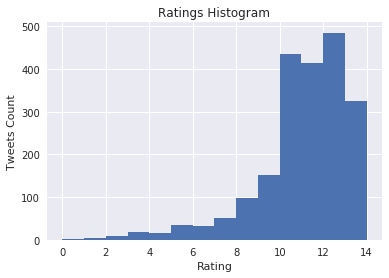

In [62]:
#We can also visually understand the distribution of ratings with an histogram:
df_master['rating_numerator'].plot(kind = 'hist', bins = 14)
plt.ylabel('Tweets Count')
plt.xlabel('Rating')
plt.title('Ratings Histogram');

`Insight` The ratings distribution is skewed to the left, according to what we expected given that 80% of ratings are 10 or up.

### `Dog Stage` 

In [63]:
#What dog stages are more common? (not considering 'None')
stage_rank = df_master[df_master.stage != 'None'].stage.value_counts()
print(stage_rank)

pupper     233
doggo      79 
puppo      29 
floofer    4  
Name: stage, dtype: int64


In [64]:
#What dog stage has more favourite counts?
stage_fav = df_master[df_master.stage != 'None']
stage_fav = stage_fav.groupby(['stage'])
stage_fav = stage_fav['favorite_count'].sum()
stage_fav = stage_fav.sort_values(ascending = False)
stage_fav

stage
pupper     1686605
doggo      1282917
puppo      659763 
floofer    74307  
Name: favorite_count, dtype: int64

In [65]:
#What dog stage have the highest favorite counts average?
stage_avg = round(stage_fav / stage_rank)
stage_avg.sort_values(ascending = False)

stage
puppo      22750.0
floofer    18577.0
doggo      16239.0
pupper     7239.0 
dtype: float64

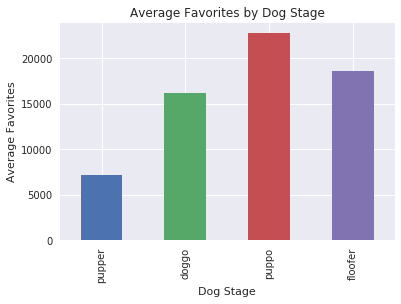

In [66]:
stage_avg.plot(kind = 'bar')
plt.ylabel('Average Favorites')
plt.xlabel('Dog Stage')
plt.title('Average Favorites by Dog Stage');

`Insight` Puppo is the stage with the highest average of favorite counts.

### `Tweets over time` 

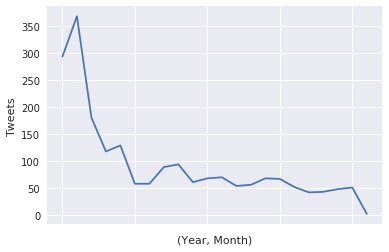

In [136]:
counts = df_twitter_clean.groupby([pd.to_datetime(df_twitter_clean['timestamp']).dt.year, pd.to_datetime(df_twitter_clean['timestamp']).dt.month]).count()
fig, ax = plt.subplots()
ax = counts.timestamp.plot(kind='line', x='timestamp', ax=ax)
ax.set_xlabel("(Year, Month)")
ax.set_ylabel("Tweets");

Note: There seems to be a bug with the plot as it is not displaying the xticks.

`Insight` The number of tweets on WeRateDogs has been decreases over time.